In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping, newton
import tqdm
import yfinance as yf
import yahoo_fin.options as ops
import cmath

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm
import stochastic_processes as stch

In [3]:
expiration_dates = ops.get_expiration_dates("aapl")

In [4]:
expiration_dates

['June 3, 2022',
 'June 10, 2022',
 'June 17, 2022',
 'June 24, 2022',
 'July 1, 2022',
 'July 8, 2022',
 'July 15, 2022',
 'August 19, 2022',
 'September 16, 2022',
 'October 21, 2022',
 'November 18, 2022',
 'December 16, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023',
 'September 15, 2023',
 'January 19, 2024',
 'June 21, 2024']

In [5]:
# s0_apple = 150.62 #15.03.2022
apple = yf.Ticker('AAPL')
s0 = apple.history().iloc[-1, 3]
s0

148.83999633789062

In [6]:
apple_option_calls = ops.get_puts("AAPL", expiration_dates[7])

In [7]:
apple_option_calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL220715P00050000,2022-05-13 3:37PM EDT,50.0,0.04,0.00,0.03,0.03,+300.00%,13,2190,89.06%
1,AAPL220715P00055000,2022-05-13 11:32AM EDT,55.0,0.03,0.00,0.03,0.00,-,550,0,82.03%
2,AAPL220715P00060000,2022-05-13 12:19PM EDT,60.0,0.02,0.02,0.03,0.00,-,12,469,78.52%
3,AAPL220715P00065000,2022-05-13 11:31AM EDT,65.0,0.05,0.03,0.04,0.00,-,111,1940,74.22%
4,AAPL220715P00070000,2022-05-16 10:02AM EDT,70.0,0.06,0.04,0.06,0.00,-,300,2158,70.70%


In [57]:
# apple_option_calls.to_csv('apple_option_put_july_15_2022_s0_146_009.csv')

In [95]:
# apple_option_calls.head()

In [8]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [9]:
apple_spread = apple_option_calls.loc[:, 'Ask'] - apple_option_calls.loc[:, 'Bid']

In [8]:
from datetime import datetime

In [11]:
expr_date = datetime.strptime(expiration_dates[7], '%B %d, %Y')
expr_date

datetime.datetime(2022, 7, 15, 0, 0)

In [12]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 5, 16, 17, 33, 45, 396501)

In [13]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.16153319644079397

In [14]:
(expr_date - today_date).days

59

In [6]:
apple_option_calls = pd.read_csv('apple_option_put_may_06_2022.csv')
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [251]:
apple_iv = apple_option_calls.loc[:, 'Implied Volatility']

In [9]:
expr_date = datetime.strptime('May 06, 2022', '%B %d, %Y')

In [10]:
maturity = expr_date - datetime.strptime('April 10, 2022', '%B %d, %Y')
maturity = maturity.days/365.25
maturity

0.07118412046543464

In [11]:
N = 500
T = maturity
r = 0.05
rho1 = 0.01
# s0 = 174.62

# type_option = 'c'
type_option = 'p'

In [222]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], T, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [223]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.001, 2), (0.0001, 1.5), (0.0001, 1.5), (-1, 1))

K = apple_strikes
marketPrice = apple_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 0.37988889907984535
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02455622, -0.00094098,  0.01291526, -0.00640232, -0.08605055,
       -0.0004998 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 119
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([ 0.21437474,  2.02832845,  0.02059559,  0.48213803,  0.1372553 ,
       -0.52473767])

In [224]:
np.sqrt(params_heston_COS.fun)

0.6163512789634215

In [225]:
r_h, kappa_h, gamma_h, vbar_h, v0_h, rho_h = params_heston_COS.x

In [200]:
cf = chf.ChFHestonModel(r_h, T, kappa_h, gamma_h, vbar_h, v0_h, rho_h)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

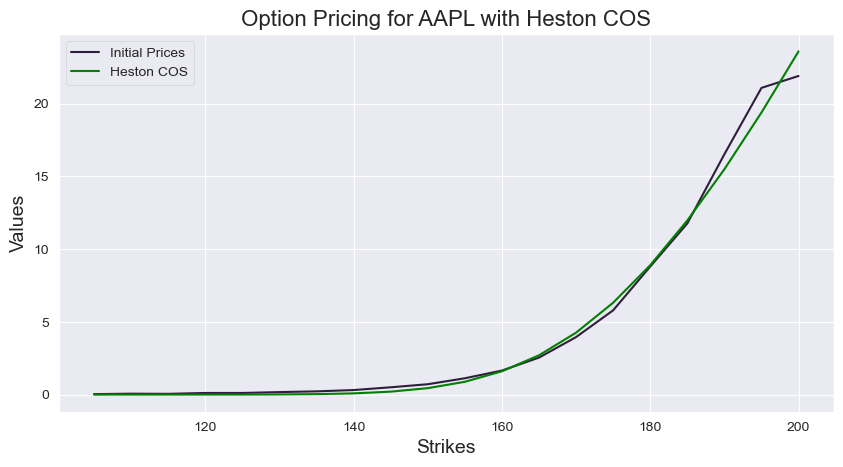

In [201]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [237]:
def calibrationBates_SIR_SC(CP, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    
    # x = [k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[10], x[3], x[4], x[11], x[5], x[6], x[7], x[8], x[16], x[14],
                               x[15], x[9], x[13], x[12], K, marketPrice, s0)

    #[k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.05, 0.4, 0.5, -0.7, 0.001, 0, 1, 0.05])
#     pars  = minimize(f_obj, initial, method='nelder-mead', options = {'xtol': 1e-05, 'disp': False,'maxiter':1000})
    
    xmin = [0.001, 0.001, 0.0001, 0.0005, 0.001, 0.0001, 0.0005, -0.99, -0.99, 0.0001, 0.0001, 0.4, -1, 0.0001, -10, 0.0001, 0.0001]
#     xmax = [2, 0.3, 0.4, 0.3, 0.4, 0.4, 0.2, 0.8, 0.8, 0.3, 0.99, 0.99]  
    xmax = [5, 0.7, 1.5, 2, 3, 2, 1, 0.6, 0.9, 1.7, 4, 5, 1, 0.3, 10, 15, 5] 
    
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
#     pars  = minimize(f_obj, x0=initial, method='nelder-mead', tol=1e-6, options = {'maxiter': 100, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    kr_est = pars.x[10]
    krho_est = pars.x[11]
    rho0_est = pars.x[12]
    r0_est = pars.x[13]
    muJ_est = pars.x[14]
    sigmaJ_est = pars.x[15]
    xip_est = pars.x[16]
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est, "murho":murho_est, \
                   "sigmarho":sigmarho_est, "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, 'xip': xip_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [238]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
#     errorVector = valCOS - marketPrice
    value = errorVector
#     value = np.linalg.norm(errorVector)

    return value

In [239]:
T = maturity
tau = T
# s0 = 174.62
type_option = 'p'

# P0T = lambda T: np.exp(0.0005*T)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xip = calibratedParms.get('xip')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 0.366197543889653
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.46864765e-06,  2.42828091e-02, -7.22628068e-03,  1.06581410e-06,
        1.77635684e-07, -4.44089210e-07, -1.05471187e-07, -1.18238752e-06,
       -3.40838469e-06, -1.83336679e-04,  3.01203507e-04, -6.60582696e-07,
       -4.77895499e-05, -2.83775614e-02, -6.94599933e-04,  1.69709803e-03,
       -1.67543757e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1098
      nit: 51
     njev: 61
   status: 0
  success: True
        x: array([ 7.18884889e-01,  1.00000000e-03,  1.00000000e-04,  3.01482161e-01,
        1.00030533e-01,  2.01627018e-01,  4.98738353e-01,  8.63557038e-02,
        1.04406178e-01,  1.46196720e-01,  3.98887277e-01,  5.03377425e-01,
       -5.18356215e-01,  3.00000000e-01,  2.51340215e-02,  1.16285230e+00,
        9.73639412e-02])


In [240]:
k_b, gamma_b, vb_b, kr_b, gammar_b, mur_b, krho_b, murho_b, sigmarho_b, rho4_b, rho5_b, xip_b, muJ_b, sigmaJ_b, v0_b, r0_b, rho0_b = k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0

In [26]:
np.sqrt(errorFinal)

0.6051425814546957

In [27]:
round(errorFinal, 9)

0.366197544

In [28]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

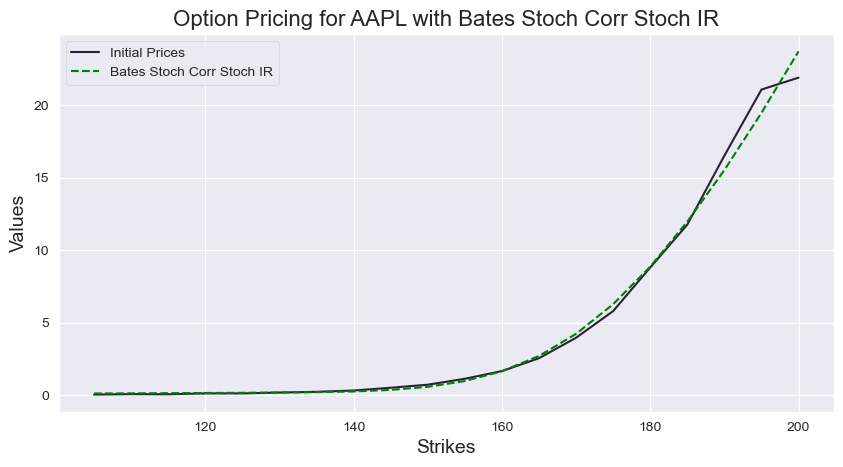

In [29]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [30]:
print(f'r0: {r0}, v0: {v0}, rho0: {rho0}, muJ: {muJ}, sigmaJ: {sigmaJ}')

r0: 0.3, v0: 0.1461967201890142, rho0: -0.5183562152474294, muJ: 0.02513402149863523, sigmaJ: 1.162852295560627


In [31]:
np.mean((marketPrice.values - valCOS.T[0])**2)

0.366197543889653

In [32]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'murho', 'sigmarho', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,murho,sigmarho,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.146197,0.718885,0.001,0.0001,0.398887,0.301482,0.100031,0.503377,0.201627,0.498738,0.086356,0.104406,0.025134,1.162852,0.3,-0.518356,0.097364


Optimal parameters for H1-HW are: gamma = 1.046, vBar = 0.055, Rxv = -0.855, v0 = 0.106
Final error for H1HW = 0.664785673


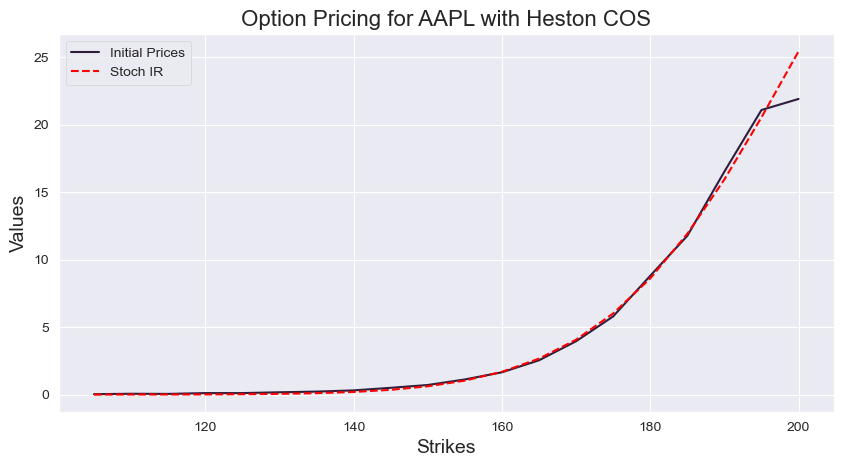

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize

i   = complex(0.0,1.0)

# Time step 
dt = 0.0001

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd_StochIR(cf,CP,S0,tau,K,N,L,P0T):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
    # P0T  - Zero-coupon bond for maturity T.

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(OptionType.PUT,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = K * np.real(mat.dot(temp))     
    
    # We use the put-call parity for call options

    if CP == OptionType.CALL:
        value = value + S0 - K * P0T
        
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def meanSqrtV_3(kappa,v0,vbar,gamma):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t)))
    kappaBar = lambda t: 4.0*kappa*v0*np.exp(-kappa*t)/(gamma*gamma*(1.0-np.exp(-kappa*t)))
    temp1 = lambda t: np.sqrt(2.0*c(t))* sp.gamma((1.0+delta)/2.0)/sp.gamma(delta/2.0)*sp.hyp1f1(-0.5,delta/2.0,-kappaBar(t)/2.0)
    return temp1

def C_H1HW(u,tau,lambd):
    i = complex(0.0,1.0)
    C = (i*u - 1.0)/lambd * (1-np.exp(-lambd*tau))
    return C

def D_H1HW(u,tau,kappa,gamma,rhoxv):
    i = complex(0.0,1.0)
    
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    D  = (1.0-np.exp(-D1*tau))/(gamma*gamma*(1.0-g*np.exp(-D1*tau)))\
        *(kappa-gamma*rhoxv*i*u-D1)
    return D
    
def A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr):
    i  = complex(0.0,1.0)
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    
    # Function theta(t)

    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))  

    # Integration within the function I_1

    N  = 500
    z  = np.linspace(0,tau-1e-10,N)
    f1 = (1.0-np.exp(-lambd*z))*theta(tau-z)
    value1 = integrate.trapz(f1,z)
    
    # Note that I_1_adj also allows time-dependent theta 
    # Therefore it is not exactly the same as in the book

    I_1_adj = (i*u-1.0) * value1
    I_2     = tau/(gamma**2.0) *(kappa-gamma*rhoxv*i*u-D1) - 2.0/(gamma**2.0)*np.log((1.0-g*np.exp(-D1*tau))/(1.0-g))
    I_3     = 1.0/(2.0*np.power(lambd,3.0))* np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    
    meanSqrtV = meanSqrtV_3(kappa,v0,vbar,gamma)
    f2        = meanSqrtV(tau-z)*(1.0-np.exp(-lambd*z))
    value2    = integrate.trapz(f2,z)
    I_4       = -1.0/lambd * (i*u+u**2.0)*value2
    
    return I_1_adj + kappa*vbar*I_2 + 0.5*eta**2.0*I_3+eta*rhoxr*I_4

def ChFH1HWModel(P0T,lambd,eta,tau,kappa,gamma,vbar,v0,rhoxv, rhoxr):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    r0 =f0T(0.00001)
    C = lambda u: C_H1HW(u,tau,lambd)
    D = lambda u: D_H1HW(u,tau,kappa,gamma,rhoxv)
    A = lambda u: A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr)
    cf = lambda u: np.exp(A(u) + C(u)*r0 + D(u)*v0 )
    return cf


def calibrationH1HW_Global(CP,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0, eta, kappa, lambda, rxr]
    f_obj = lambda x: TargetValH1HW(CP,x[5],x[0],x[1],x[7],x[2],x[3],x[4],x[6],K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05, 0.01, 0.3, 0.04, 0.4])
    
    # The bounds

    xmin = [0.0001, 0.001,-0.99, 0.0001, 0.001, 0.001, 0.001, -1]
    xmax = [2,  1.5,  0.99, 1, 0.7, 0.7, 0.7, 1]    
    
    # Rewrite the bounds as required by L-BFGS-B

    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    pars  = minimize(f_obj,initial,bounds=bounds, tol=1e-05)
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    eta = pars.x[4]
    kappa = pars.x[5]
    lambd = pars.x[6]
    rxr = pars.x[7]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est, "eta": eta, "kappa": kappa, "lambda": lambd, "rxr": rxr,'ErrorFinal':pars.fun}
    return parmCalibr

def TargetValH1HW(CP,kappa,gamma,vBar,Rxr,Rxv,v0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 500
    L = 10 
    cf = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0, Rxv, Rxr)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    
    # Target value is a norm of the error vector

#     value       = np.linalg.norm(errorVector)   
    value = errorVector
    return value


CP  = OptionType.PUT
# global valCOS_H1HW

#     S0    = 174.62    
S0 = s0


P0T = lambda T: np.exp(0.0012*T+0.0007)

N = 500
L = 10


T = maturity

K = apple_strikes
referencePrice = apple_market_price
calibratedParms =  calibrationH1HW_Global(CP,K,referencePrice,S0,T,P0T)

gamma = calibratedParms.get('gamma')
vBar  = calibratedParms.get('vBar')
Rxv   = calibratedParms.get('Rxv')
v0    = calibratedParms.get('v0')
eta = calibratedParms.get('eta')
kappa = calibratedParms.get('kappa')
lambd = calibratedParms.get('lambda')
Rxr = calibratedParms.get('rxr')
errorH1HW = calibratedParms.get('ErrorFinal')   

cf2 = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0,Rxv, Rxr)
valCOS_H1HW = CallPutOptionPriceCOSMthd_StochIR(cf2, CP, S0, T, K, N, L,P0T(T))


print("Optimal parameters for H1-HW are: gamma = {0:.3f}, vBar = {1:.3f}, Rxv = {2:.3f}, v0 = {3:.3f}".format(gamma,vBar,Rxv,v0))
print('Final error for H1HW = {0}'.format(round(errorH1HW, 9)))

plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, apple_market_price, label='Initial Prices')
plt.plot(K, valCOS_H1HW, '--', color='red', label='Stoch IR')

plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()
    

In [38]:
def zcb_curve(tau, kr, mur, gammar, rt):
    p = np.sqrt(kr**2 + 2*gammar**2)
    bfun = (2*(np.exp(p*tau)-1))/(2*p + (np.exp(p*tau)-1)*(p + kr))
    afun = (2*kr*mur)/(gammar**2) * np.log((2*p*np.exp((p+kr)*tau/2))/(2*p + (np.exp(p*tau)-1)*(p + kr)))
    
    return np.exp(afun - bfun*rt)

In [39]:
zcb0 = zcb_curve(tau, kr, mur, gammar, r0)
zcb0

0.9588630154900779

In [40]:
numberPaths = 20000
N = 500
type_option = 'p'

time, S, M = mcm.bates_SC_SIR_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0)

In [41]:
option_bates_stoch_AES = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])

In [42]:
option_bates_stoch_AES_Tm = mcm.optionPriceMC_Stoch_Tm(type_option, S[:, -1], K, T, zcb0)

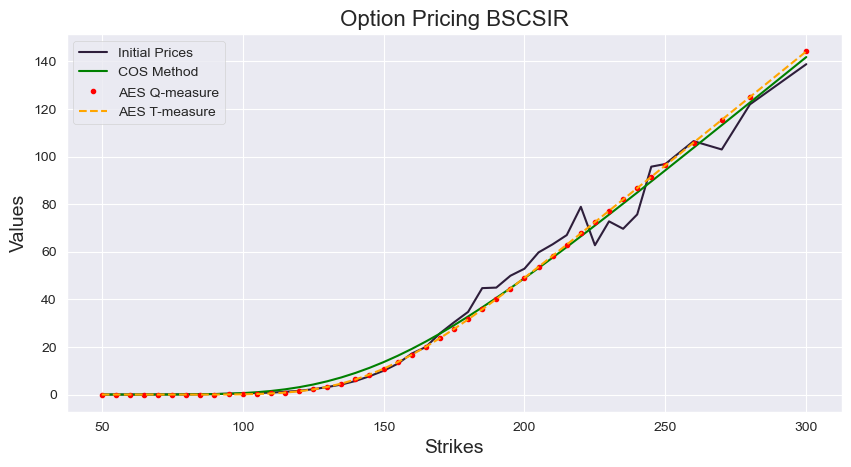

In [43]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, valCOS, color='green', label='COS Method')
plt.plot(apple_strikes, option_bates_stoch_AES, '.',color='red', label='AES Q-measure')
plt.plot(apple_strikes, option_bates_stoch_AES_Tm, '--',color='orange', label='AES T-measure')
        
plt.title('Option Pricing BSCSIR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [44]:
r0

0.2651932007604574

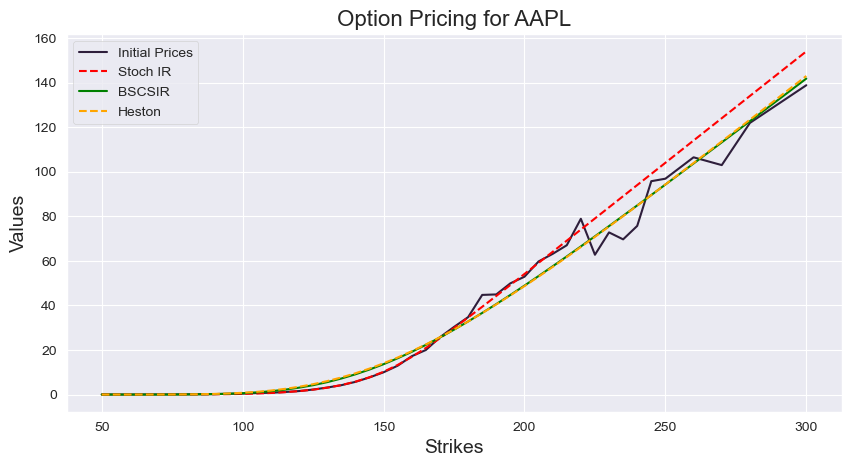

In [46]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, apple_market_price, label='Initial Prices')
plt.plot(K, valCOS_H1HW, '--', color='red', label='Stoch IR')
plt.plot(K, valCOS, color='green', label='BSCSIR')
plt.plot(K, option_heston_cos, '--', color='orange', label='Heston')

plt.title('Option Pricing for AAPL', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [47]:
np.mean((1/M[:, -1]))

0.9588048321100474

In [48]:
zcb0

0.9588630154900779

In [49]:
import numpy as np

In [50]:
dt = 0.0001 
P0T = lambda T: np.exp(0.0012*T+0.0007) 
f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
f0T(0.00001)

-0.0011999999998231958

## BSCSIR with stochastic correlation by DCL process 

In [241]:
def calibrationBates_SIR_SC_DCL(CP, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
   
    # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9],
                               x[10], x[11], x[12], x[13], x[14], x[15], K, marketPrice, s0)

                        # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.2,   0.2,   2,   1.5,  0.1, 0.5, 0.05,  0,    1, 0.04,   0.05, 0.7])

            # k,    gamma,   vb,     kr,   gammar, mur, krho, delta, rho4, rho5,  xip,    muJ, sigmaJ, v0, r0, rho0
    xmin = [0.0001, 0.0001, 0.001, 0.0005, 0.001, 0.0001, 1, 1,     -0.99, -0.99, 0.001, -10,   -10,   0.0001, 0.0001, -0.9999]
    xmax = [5,       0.7,   1.5,     2,      3,     2,   5,  4,      0.98, 0.98,  5,      10, 10,      0.3, 0.3, 0.9999] 
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    kr_est = pars.x[3]
    gammar_est = pars.x[4]
    mur_est = pars.x[5]
    krho_est = pars.x[6]
    delta_est = pars.x[7]
    rho4_est = pars.x[8]
    rho5_est = pars.x[9]
    xip_est = pars.x[10]
    muJ_est = pars.x[11]
    sigmaJ_est = pars.x[12]
    v0_est = pars.x[13]
    r0_est = pars.x[14]
    rho0_est = pars.x[15]
   
   
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est,\
                   "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, "xip": xip_est, "delta": delta_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [242]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    value = errorVector

    return value

In [243]:
T = maturity
tau = T
type_option = 'p'

# P0T = lambda T: np.exp(0.0005*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC_DCL(type_option, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xip = calibratedParms.get('xip')
delta = calibratedParms.get('delta')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 0.34417231810397186
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.00390834e-04, -2.15575556e-02,  2.03118078e-03,  3.30246941e-04,
        8.13260570e-04,  9.99200723e-08, -4.74176257e-05,  6.90558726e-06,
       -1.18569044e-03,  4.90829599e-05,  2.27984831e-01,  2.69340107e-04,
       -9.07407488e-04,  1.81571425e-02, -3.12238235e-02, -2.12239170e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1037
      nit: 46
     njev: 61
   status: 0
  success: True
        x: array([ 4.92265513e+00,  7.00000000e-01,  2.88905065e-02,  2.06787392e-01,
        2.60773893e-02,  1.97966570e-01,  1.99921737e+00,  1.49998786e+00,
        1.01393041e-01,  4.32262252e-01,  1.22411157e-03, -2.28685720e+00,
       -3.39274841e+00,  1.35731007e-01,  3.00000000e-01,  5.31167747e-01])


In [247]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS_DCL = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

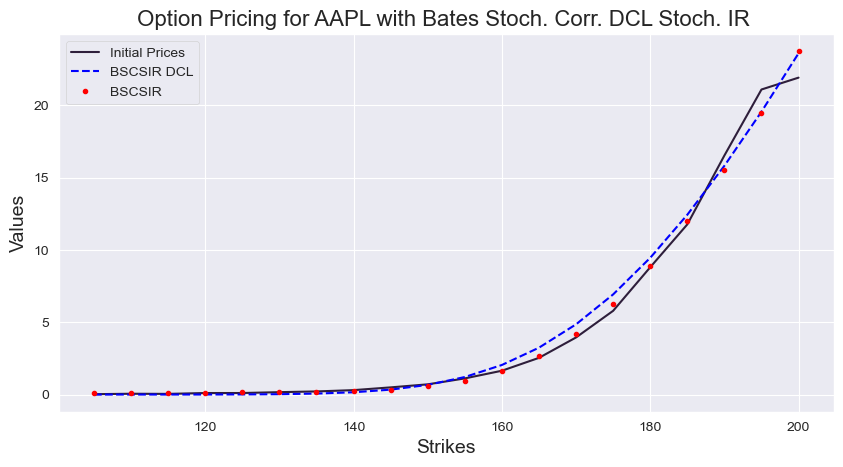

In [248]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS_DCL, '--', color='blue', label='BSCSIR DCL')
plt.plot(K, valCOS, '.', color='red', label='BSCSIR')
        
plt.title('Option Pricing for AAPL with Bates Stoch. Corr. DCL Stoch. IR ', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [58]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'delta', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,delta,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.0001,0.722711,0.174767,0.053799,0.0005,0.001,0.196152,1.845332,1.500212,0.026707,0.767216,-8.095879,-4.731257,0.3,0.9999,0.002489


## Implied Volatility

In [218]:
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == 'call':
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == 'put':
        value = stats.norm.cdf(-d2) * K * np.exp(-r * tau) - stats.norm.cdf(-d1)*S_0
    return value

# Implied volatility method
def ImpliedVolatilityBlack76(marketPrice, K):
    sigmaGrid = np.linspace(0.01, 2.0, 5000)
    optPriceGrid = BS_Call_Put_Option_Price('put', s0, K, sigmaGrid, T, r0)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Put_Option_Price('put', s0, K, sigma, T, r0) - marketPrice, 1.0)
    impliedVol = newton(func, sigmaInitial, tol=1e-11)

    return impliedVol

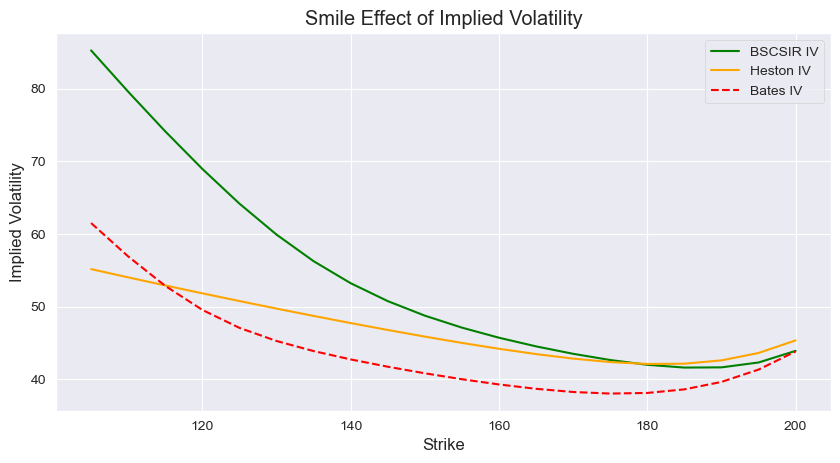

In [250]:
gamma = 1
plt.subplots(figsize=(10, 5), dpi=100)

cf = chf.ChFBates_StochIR_StochCor(tau, T, k_b, gamma, vb_b, kr_b, gammar_b, mur_b, krho_b, murho_b,\
                                   sigmarho_b, rho4_b, rho5_b, xip_b, muJ_b, sigmaJ_b, v0_b, r0_b, rho0_b)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

IV =np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV[idx] = ImpliedVolatilityBlack76(valCOS[idx], K[idx])
    
cf_h = chf.ChFHestonModel(r_h, T, kappa_h, gamma, vbar_h, v0_h, rho_h)
option_heston_cos = exm.CallPutOptionPriceCOS(cf_h, type_option, s0, r, T, K, N, 10).T[0]

IV_heston =np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_heston[idx] = ImpliedVolatilityBlack76(option_heston_cos[idx], K[idx])
    
cf_b = chf.ChFBatesModel(r0, tau, kappa, gamma, vbar, v0, rho, xip, muJ, sigmaJ) 
bates_cos = exm.optionPriceCOSMthd_StochIR(cf_b, type_option, s0, T, K, N, L)
IV_bates =np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_bates[idx] = ImpliedVolatilityBlack76(bates_cos[idx], K[idx])
    
cf_dcl = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS_DCL = exm.optionPriceCOSMthd_StochIR(cf_dcl, type_option, s0, T, K, N, L)
IV_DCL = np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_DCL[idx] = ImpliedVolatilityBlack76(valCOS_DCL[idx], K[idx])

plt.plot(K, IV*100.0, c='green', label=f'BSCSIR IV')
plt.plot(K, IV_heston*100.0, c='orange', label=f'Heston IV')
plt.plot(K, IV_bates*100.0,'--', c='red', label=f'Bates IV')
# plt.plot(K, IV_DCL*100.0,'--', c='blue', label=f'DCL IV')

plt.legend()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Smile Effect of Implied Volatility')
plt.show()